In [22]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import pickle
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Data Understanding

In [2]:
root = r"Images histopathologies" 
pattern = re.compile(r'^[0-9]+_idx[0-9]+_x[0-9]+_y[0-9]+_class[01]\.png$')

bad_files = []
total = 0

for root_dir, _, files in os.walk(root):
    for f in files:
        if f.lower().endswith(".png"):
            total += 1
            if not pattern.match(f):
                bad_files.append(os.path.join(root_dir, f))

print(f"Total PNG files scanned: {total}")
print(f"Invalid filenames found: {len(bad_files)}\n")

if bad_files:
    for bf in bad_files[:30]:
        print("BAD:", bf)
    if len(bad_files) > 30:
        print("... and more.")
else:
    print("All filenames are valid.")


Total PNG files scanned: 277524
Invalid filenames found: 0

All filenames are valid.


In [3]:
total_count = 0
class_0_count = 0
class_1_count = 0

for patient_id in os.listdir(root):
    patient_path = os.path.join(root, patient_id)
    if not os.path.isdir(patient_path):
        continue
    
    for class_label in ["0", "1"]:
        class_path = os.path.join(patient_path, class_label)
        if not os.path.isdir(class_path):
            continue
        
        count = len([f for f in os.listdir(class_path)
                     if f.endswith(".png")])

        total_count += count

        if class_label == "0":
            class_0_count += count
        else:
            class_1_count += count

print("Total images:", total_count)
print("Class 0 (non-IDC):", class_0_count)
print("Class 1 (IDC):", class_1_count)

Total images: 277524
Class 0 (non-IDC): 198738
Class 1 (IDC): 78786


In [4]:
rows = []

for patient_id in os.listdir(root):
    patient_path = os.path.join(root, patient_id)
    if not os.path.isdir(patient_path):
        continue
    
    for label in ["0", "1"]:
        label_path = os.path.join(patient_path, label)
        if not os.path.isdir(label_path):
            continue
        
        for fname in os.listdir(label_path):
            if fname.endswith(".png"):
                rows.append({
                    "patient_id": int(patient_id),
                    "label": int(label),
                    "filename": os.path.join(label_path, fname)
                })

df = pd.DataFrame(rows)
print(df.head())
print(df.shape)

   patient_id  label                                           filename
0       10253      0  Images histopathologies\10253\0\10253_idx5_x10...
1       10253      0  Images histopathologies\10253\0\10253_idx5_x10...
2       10253      0  Images histopathologies\10253\0\10253_idx5_x10...
3       10253      0  Images histopathologies\10253\0\10253_idx5_x10...
4       10253      0  Images histopathologies\10253\0\10253_idx5_x10...
(277524, 3)


In [5]:
#Patient Ids dataset
patients = df["patient_id"].unique()

train_patients, test_patients = train_test_split(patients, test_size=0.2, random_state=42)
train_patients, val_patients = train_test_split(train_patients, test_size=0.1, random_state=42)

df_train_images = df[df["patient_id"].isin(train_patients)]
df_val_images = df[df["patient_id"].isin(val_patients)]
df_test_images = df[df["patient_id"].isin(test_patients)]

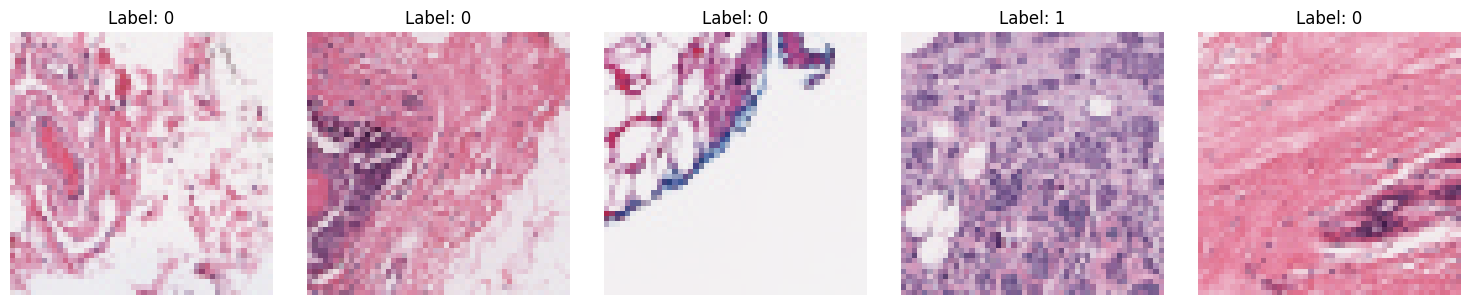

In [6]:
def Images_samples(df, n=5):
    sample = df.sample(n)   # randomly pick n rows

    plt.figure(figsize=(15, 3))

    for i, (_, row) in enumerate(sample.iterrows()):
        img = Image.open(row["filename"])

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Label: {row['label']}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Images_samples(df_train_images, n=5)

# Data preparation

In [7]:
#Images Datasets
IMG_SIZE = 50 

#maps filename to actual image data
def load_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.image.convert_image_dtype(img, tf.float32)  # scales to [0,1]
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((df_train_images["filename"], df_train_images["label"]))
train_ds = train_ds.map(load_preprocess).shuffle(5000).batch(64).prefetch(1) #shuffle pour rendre les images aleatoires chaque epoch

val_ds = tf.data.Dataset.from_tensor_slices((df_val_images["filename"], df_val_images["label"]))
val_ds = val_ds.map(load_preprocess).batch(64).prefetch(1)

test_ds = tf.data.Dataset.from_tensor_slices((df_test_images["filename"], df_test_images["label"]))
test_ds = test_ds.map(load_preprocess).batch(64).prefetch(1)

# Modeling

## Fresh trained model

In [7]:
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(1, activation='sigmoid') 
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

We used a CNN because histopathology images contain local spatial patterns that must be analyzed at multiple levels (edges, textures, tissue structures). Convolution layers automatically learn these features while keeping the number of parameters low through weight sharing. Pooling layers add robustness and reduce overfitting. The architecture extracts hierarchical patterns and outputs a probability through a sigmoid neuron, making it well-suited for IDC vs non-IDC binary classification.

In [8]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [9]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 596s 195ms/step - accuracy: 0.8454 - loss: 0.4191 - val_accuracy: 0.8275 - val_loss: 0.3985
Epoch 2/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 613s 192ms/step - accuracy: 0.8641 - loss: 0.3211 - val_accuracy: 0.8119 - val_loss: 0.5001
Epoch 3/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 589s 193ms/step - accuracy: 0.8702 - loss: 0.3093 - val_accuracy: 0.8517 - val_loss: 0.3831
Epoch 4/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 589s 193ms/step - accuracy: 0.8727 - loss: 0.3029 - val_accuracy: 0.8476 - val_loss: 0.4245
Epoch 5/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 588s 193ms/step - accuracy: 0.8756 - loss: 0.2962 - val_accuracy: 0.8426 - val_loss: 0.3945
Epoch 6/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 619s 194ms/step - accuracy: 0.8767 - loss: 0.2917 - val_accuracy: 0.8531 - val_loss: 0.4458
Epoch 8/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 618s 192ms/step - accuracy: 0.8781 - loss: 0.2922 - val_accuracy: 0.8501 - val_loss: 0.4264
Epoch 9/10
3035/3035 ━━━━━━━━━━━━━━━━━━━━ 620s 191ms/step - ac

## Resnet pre-trained model

In [8]:
base_model = ResNet50(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet"
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


In [9]:
base_model.trainable = False

resnet_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')   # binary classification
])

resnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
resnet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
EPOCHS = 5

history_resnet = resnet_model.fit(
    train_ds,          
    validation_data=val_ds,
    epochs=EPOCHS
)


# Evaluation

In [24]:
cnn_model = load_model("breast_cancer_image_cnn.keras")
resnet_model = load_model("breast_cancer_resnet50.keras")

In [25]:
cnn_loss, cnn_acc = cnn_model.evaluate(test_ds)
resnet_loss, resnet_acc = resnet_model.evaluate(test_ds)
print(f"CNN Model - Test Accuracy: {cnn_acc:.4f}, Test Loss: {cnn_loss:.4f}")
print(f"ResNet50 Model - Test Accuracy: {resnet_acc:.4f}, Test Loss: {resnet_loss:.4f}")

899/899 ━━━━━━━━━━━━━━━━━━━━ 66s 73ms/step - accuracy: 0.8569 - loss: 0.3918
899/899 ━━━━━━━━━━━━━━━━━━━━ 695s 765ms/step - accuracy: 0.8578 - loss: 0.3516 
CNN Model - Test Accuracy: 0.8569, Test Loss: 0.3918
ResNet50 Model - Test Accuracy: 0.8578, Test Loss: 0.3516


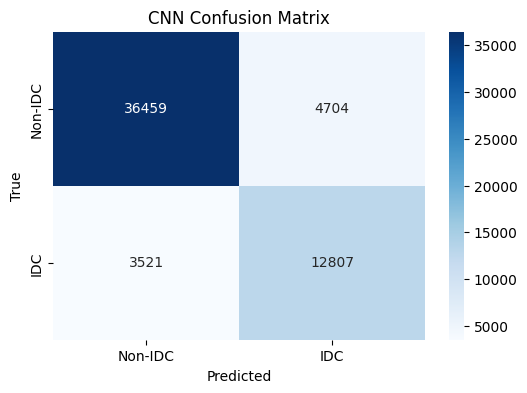

CNN Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     41163
           1       0.73      0.78      0.76     16328

    accuracy                           0.86     57491
   macro avg       0.82      0.84      0.83     57491
weighted avg       0.86      0.86      0.86     57491



In [26]:
y_true, y_pred = [], []
for images, labels in test_ds:
    preds = cnn_model.predict(images, verbose=0).ravel()
    y_pred.extend((preds > 0.5).astype(int))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-IDC','IDC'],
            yticklabels=['Non-IDC','IDC'])
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("CNN Classification Report:")
print(classification_report(y_true, y_pred))

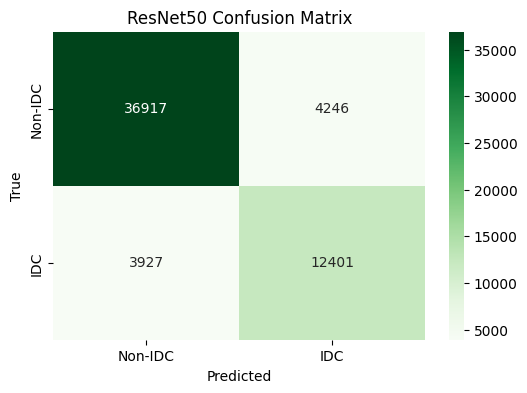

ResNet50 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     41163
           1       0.74      0.76      0.75     16328

    accuracy                           0.86     57491
   macro avg       0.82      0.83      0.83     57491
weighted avg       0.86      0.86      0.86     57491



In [27]:
y_true_r, y_pred_r = [], []
for images, labels in test_ds:
    preds = resnet_model.predict(images, verbose=0).ravel()
    y_pred_r.extend((preds > 0.5).astype(int))
    y_true_r.extend(labels.numpy())

cm_r = confusion_matrix(y_true_r, y_pred_r)
plt.figure(figsize=(6,4))
sns.heatmap(cm_r, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-IDC','IDC'],
            yticklabels=['Non-IDC','IDC'])
plt.title("ResNet50 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("ResNet50 Classification Report:")
print(classification_report(y_true_r, y_pred_r))

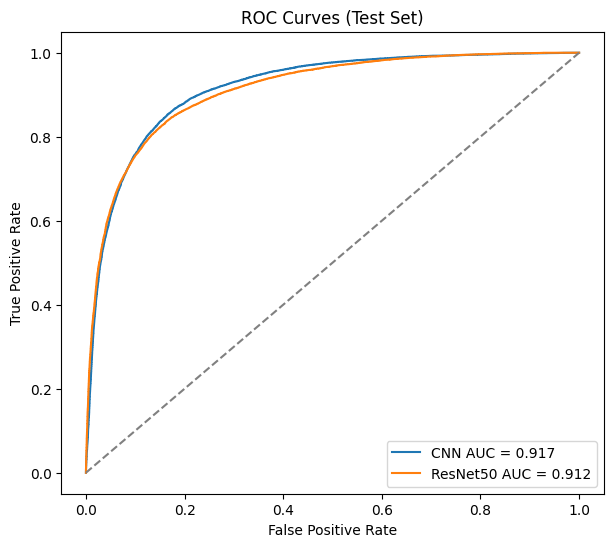

In [28]:
y_scores, y_scores_r = [], []

for images, labels in test_ds:
    y_scores.extend(cnn_model.predict(images, verbose=0).ravel())
    y_scores_r.extend(resnet_model.predict(images, verbose=0).ravel())

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

fpr_r, tpr_r, _ = roc_curve(y_true_r, y_scores_r)
roc_auc_r = auc(fpr_r, tpr_r)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"CNN AUC = {roc_auc:.3f}")
plt.plot(fpr_r, tpr_r, label=f"ResNet50 AUC = {roc_auc_r:.3f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.show()

In [15]:
model.save("breast_cancer_image_cnn.keras")
print("Model saved!")

Model saved!


In [13]:
resnet_model.save("breast_cancer_resnet50.keras")